In [ ]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.3 MB/s eta 0:00:00


In [ ]:
#Importing libraries
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score, adjusted_rand_score
from sklearn.cluster import MiniBatchKMeans, DBSCAN, AgglomerativeClustering

In [ ]:
#1
#Loading the Fashion-MNIST dataset
from tensorflow import keras
from keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#2
#Reshaping the image data in a 2D array for MinMaxScaler using (MinMaxScaler can be used only for maximum 2D_dimension arrays)
x_train_full_flat = x_train.reshape(-1, 28 * 28)  # (60000, 784)
x_test_flat = x_test.reshape(-1, 28 * 28)  # (10000, 784)

#Using MinMaxScaler for normilization
scaler = MinMaxScaler()
x_train_full_scaled = scaler.fit_transform(x_train_full_flat)
x_test_scaled = scaler.transform(x_test_flat)

#Spliting the Train Data to train and validation datasets
x_train_scaled, x_val_scaled, y_train, y_val = train_test_split(
    x_train_full_scaled, y_train, test_size=0.2, random_state=42
)

#Reshaping the data back into the original 28x28 image format
x_train_orig_form = x_train_scaled.reshape(-1, 28, 28)
x_val_orig_form = x_val_scaled.reshape(-1, 28, 28)
x_test_orig_form = x_test_scaled.reshape(-1, 28, 28)

#Showing datasets' shapes
print(f"Training data shape: {x_train_orig_form.shape}, Labels shape: {y_train.shape}")
#print(x_train, y_train)
print(f"Validation data shape: {x_val_orig_form.shape}, Labels shape: {y_val.shape}")
#print(x_val, y_val)
print(f"Test data shape: {x_test_orig_form.shape}, Labels shape: {y_test.shape}")
#print(x_test, y_test)

Training data shape: (48000, 28, 28), Labels shape: (48000,)
Validation data shape: (12000, 28, 28), Labels shape: (12000,)
Test data shape: (10000, 28, 28), Labels shape: (10000,)


In [ ]:
#4
#printing random images from dataset
def display_original_and_reconstructed(model, x_data, y_data, num_classes=10, title="Original and Reconstructed Images"):
    """
    Display original and reconstructed images for a given model.

    Args:
        model: The dimensionality reduction model (e.g., SAE or PCA).
        x_data: The input data to be reconstructed.
        y_data: The labels corresponding to the data.
        num_classes: Number of classes to display.
        title: Title of the plot.
    """
    fig, axes = plt.subplots(2, num_classes, figsize=(15, 5))

    # Select one random image from each class
    original_images = []
    for label in range(num_classes):
        indices = np.where(y_data == label)[0]
        random_index = np.random.choice(indices)
        original_images.append(x_data[random_index])

    # Check if the model supports reconstruction
    reconstructed_images = None
    try:
        if hasattr(model, "predict") and callable(getattr(model, "predict")):  # SAE
            reconstructed_images = model.predict(np.array(original_images))
        elif hasattr(model, "inverse_transform") and callable(getattr(model, "inverse_transform")):  # PCA
            encoded = model.transform(np.array(original_images).reshape(len(original_images), -1))
            reconstructed_images = model.inverse_transform(encoded).reshape(len(original_images), 28, 28)
    except Exception as e:
        print(f"Reconstruction not supported or failed: {e}")

    # Display original and reconstructed images
    for label in range(num_classes):
        # Show original image
        original_img = original_images[label].reshape(28, 28)
        axes[0, label].imshow(original_img, cmap='gray')
        axes[0, label].axis('off')
        axes[0, label].set_title(f"Class {label}")

        # Show reconstructed image if available
        if reconstructed_images is not None:
            reconstructed_img = reconstructed_images[label].reshape(28, 28)
            axes[1, label].imshow(reconstructed_img, cmap='gray')
            axes[1, label].axis('off')
            axes[1, label].set_title(f"Reconstructed {label}")

    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


In [ ]:
# 5
#printing graphs to check if the dimensionality reduction technique works

# Helper function for 2D plots
def plot_2d(X_proj, y, title):
    plt.figure(figsize=(8, 6))
    for label in np.unique(y):
        plt.scatter(X_proj[y == label, 0], X_proj[y == label, 1], label=f'Class {label}')
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()

# Helper function for 3D plots
def plot_3d(X_proj, y, title):
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    for label in np.unique(y):
        ax.scatter(X_proj[y == label, 0], X_proj[y == label, 1], X_proj[y == label, 2], label=f'Class {label}')
    ax.set_title(title)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    ax.legend()
    plt.show()

In [ ]:
#6
#using the technique to encode the test dataset

def encode_with_technique(technique, data):
    """
    Applies a dimensionality reduction technique to the data and returns the encoded representation.

    Args:
        technique (object): The technique to apply (e.g. PCA or SAE Encoder).
        data (numpy.ndarray): The data to encode.

    Returns:
        numpy.ndarray: The encoded data.
    """
    if hasattr(technique, 'transform'): # If the technique has a transform (e.g. PCA)
        return technique.transform(data)
    elif hasattr(technique, 'predict'):  # If the technique is NN-based (e.g. SAE)
        return technique.predict(data)
    else:
        raise ValueError("The chosen technique does not support encoding.")


In [ ]:
#Initializing three different clustering algorithms
kmeans = MiniBatchKMeans(n_clusters=10, batch_size=100, random_state=42)
dbscan = DBSCAN(eps=3, min_samples=5)  # eps must be adjusted according to the data
agglo = AgglomerativeClustering(n_clusters=10)

In [ ]:
#7
#creating clusters using a clustering technique
def clustering(data, method):
    start_time = time.time()
    labels = method.fit_predict(data)
    end_time = time.time()
    return labels,len(np.unique(labels)),end_time - start_time

In [ ]:
#8
# Function to calculate cluster performance scores
# aka evaluate through clustering
def calculate_cluster_performance(data, labels, true_labels=None):
    silhouette = silhouette_score(data, labels)
    ch_score = calinski_harabasz_score(data, labels)
    db_score = davies_bouldin_score(data, labels)
    if true_labels is not None:
      ari_score = adjusted_rand_score(true_labels, labels)
      return silhouette, ch_score, db_score,ari_score
    return silhouette, ch_score, db_score

In [ ]:
# Initialization of DataFrame
results_df = pd.DataFrame(columns=[
    "Dim. Red. Technique", "Clustering Algorithm", "Training Time (s)",
    "Execution Time (s)", "Suggested Clusters", "Calinski-Harabasz Index",
    "Davies-Bouldin Index", "Silhouette Score", "Adjusted Rand Score"
])

In [ ]:
#9
#adding in a dataframe info about the technique and the estimated metrics

def evaluate_and_store_results(encoded_data, true_labels, dim_red_name, cluster_name,cluster_method, training_time):
    """
     Calculates metrics for clustering and stores them in a Pandas DataFrame.

    Args:
        encoded_data (numpy.ndarray): Encoded data from Dim. Red. technique or the original data.
        true_labels (numpy.ndarray): Labels of the test set for calculating metrics.
        dim_red_name (str): Name of the Dimensionality Reduction or Raw technique.
        cluster_name (str): Name of the clustering technique
        cluster_method (str): Name of the clustering technique.
        training_time (float): Training time of the Dim. Red. technique.

    Returns:
        None
    """
    global results_df

    method_labels,method_clusters,method_time = clustering(encoded_data, cluster_method)
    silhouette, ch_score, db_score,ari_score = calculate_cluster_performance(encoded_data, method_labels, true_labels)

    print(f"Time taken ({cluster_name}): {method_time:.4f} seconds")
    print(f"Number of clusters for {cluster_name}: {method_clusters}")
    print(f"Silhouette score ({cluster_name}): {silhouette:.2f}")
    print(f"CH Index ({cluster_name}): {ch_score:.2f}")
    print(f"DB Index ({cluster_name}): {db_score:.2f}")
    print(f"ARI Index ({cluster_name}): {ari_score:.2f}")

    # Updating DataFrame
    results_df = pd.concat([results_df, pd.DataFrame({
        "Dim. Red. Technique": [dim_red_name],
        "Clustering Algorithm": [cluster_name],
        "Training Time (s)": [training_time],
        "Execution Time (s)": [method_time],
        "Suggested Clusters": [method_clusters],
        "Calinski-Harabasz Index": [ch_score],
        "Davies-Bouldin Index": [db_score],
        "Silhouette Score": [silhouette],
        "Adjusted Rand Score": [ari_score]
    })], ignore_index=True)

# Showing DataFrame
#print(results_df)


In [ ]:
print("For the scaled test data:")
print("-" * 50)

# Clustering performance for kmean
evaluate_and_store_results(x_test_scaled, y_test, "Raw", "MiniBatchKMeans",kmeans,0)
print("-" * 50)

# Clustering performance for dbscan
evaluate_and_store_results(x_test_scaled, y_test, "Raw", "DBSCAN",dbscan,0)
print("-" * 50)

# Clustering performance for Agglomerative Clustering after applying dimensionality reduction
evaluate_and_store_results(x_test_scaled, y_test, "Raw", "Agglomerative Clustering",agglo,0)
print("-" * 50)


For the scaled test data:
--------------------------------------------------
Time taken (MiniBatchKMeans): 0.2462 seconds
Number of clusters for MiniBatchKMeans: 10
Silhouette score (MiniBatchKMeans): 0.14
CH Index (MiniBatchKMeans): 1249.10
DB Index (MiniBatchKMeans): 2.05
ARI Index (MiniBatchKMeans): 0.38
--------------------------------------------------


<ipython-input-11-61940bbe794a>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({


Time taken (DBSCAN): 5.9640 seconds
Number of clusters for DBSCAN: 34
Silhouette score (DBSCAN): -0.35
CH Index (DBSCAN): 29.78
DB Index (DBSCAN): 1.56
ARI Index (DBSCAN): 0.02
--------------------------------------------------
Time taken (Agglomerative Clustering): 36.2135 seconds
Number of clusters for Agglomerative Clustering: 10
Silhouette score (Agglomerative Clustering): 0.12
CH Index (Agglomerative Clustering): 1115.50
DB Index (Agglomerative Clustering): 2.05
ARI Index (Agglomerative Clustering): 0.33
--------------------------------------------------


=== PCA ===


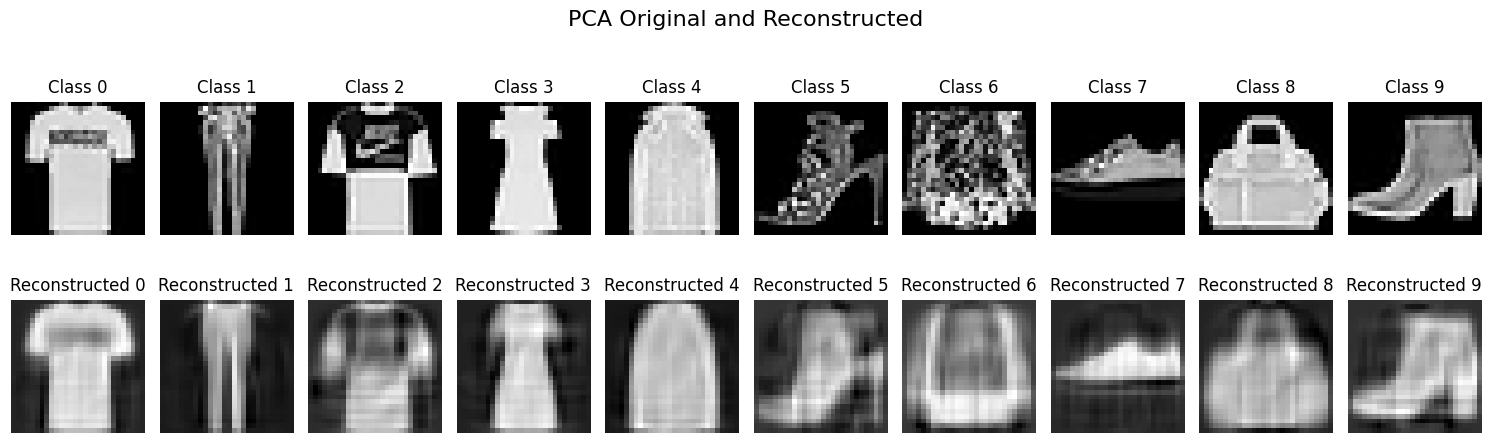

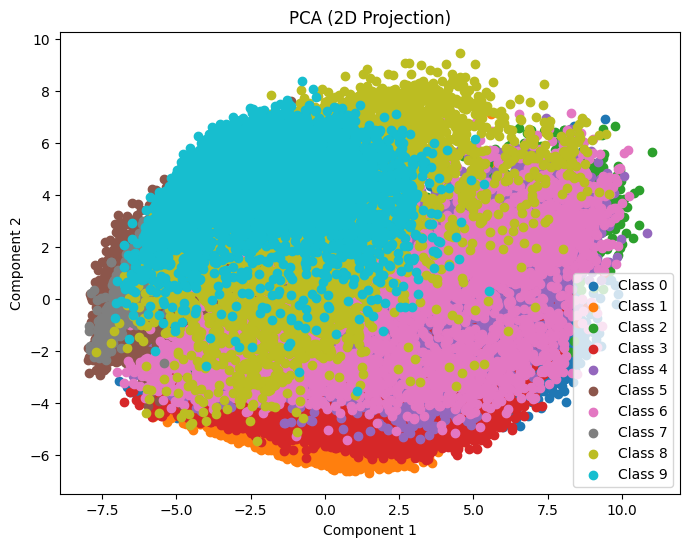

Time taken (PCA 2D): 1.5267 seconds
Silhouette score (PCA 2D): -0.03
CH Index (PCA 2D): 9151.41
DB Index (PCA 2D): 4.00


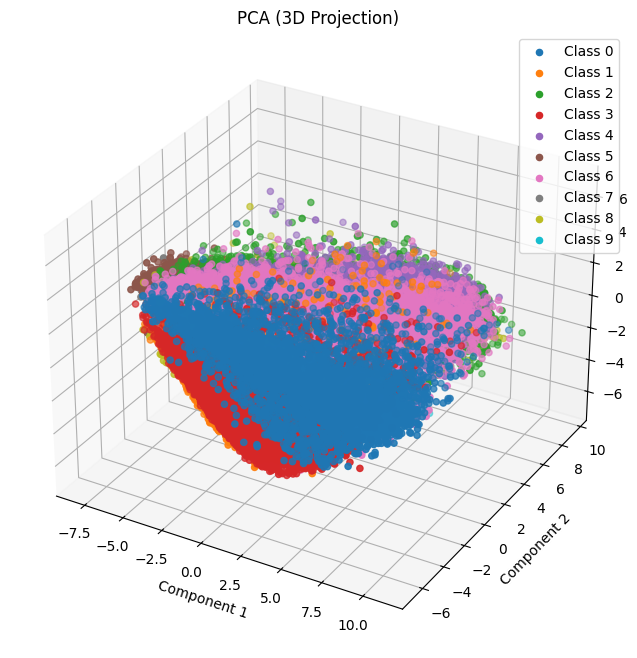

Time taken (PCA 3D): 1.5423 seconds
Silhouette score (PCA 3D): 0.01
CH Index (PCA 3D): 9015.82
DB Index (PCA 3D): 3.79
--------------------------------------------------
For the test data after PCA reduction:
--------------------------------------------------
Time taken (MiniBatchKMeans): 0.1260 seconds
Number of clusters for MiniBatchKMeans: 10
Silhouette score (MiniBatchKMeans): 0.17
CH Index (MiniBatchKMeans): 1682.77
DB Index (MiniBatchKMeans): 1.74
ARI Index (MiniBatchKMeans): 0.34
--------------------------------------------------
Time taken (DBSCAN): 2.2054 seconds
Number of clusters for DBSCAN: 21
Silhouette score (DBSCAN): -0.34
CH Index (DBSCAN): 29.47
DB Index (DBSCAN): 1.74
ARI Index (DBSCAN): 0.02
--------------------------------------------------
Time taken (Agglomerative Clustering): 16.2465 seconds
Number of clusters for Agglomerative Clustering: 10
Silhouette score (Agglomerative Clustering): 0.17
CH Index (Agglomerative Clustering): 1570.60
DB Index (Agglomerative Clu

In [ ]:
#3
# running a dimensionality reduction technic in the train data

#PCA
print("=== PCA ===")

start_time=time.time()
pca = PCA(n_components=50)  # Reducing to 50 components
X_pca = pca.fit_transform(x_train_scaled)  # Fit PCA and transform
end_time=time.time()
pca_time=end_time-start_time

num_classes = len(np.unique(y_train))  # Total number of classes

# Perform reconstruction using inverse PCA
reconstructed_images = pca.inverse_transform(X_pca)

# Select reconstructed images corresponding to the original selection
reconstructed_selected = [reconstructed_images[np.where(y_train == label)[0][0]] for label in range(num_classes)]

# Display the Original and Reconstructed  Images
display_original_and_reconstructed(pca, x_train_orig_form, y_train, title="PCA Original and Reconstructed")

# PCA 2D projection
start_time_2d = time.time()  # Start time for 2D
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(x_train_scaled)
end_time_2d = time.time()  # End time for 2D
pca_time_2d = end_time_2d - start_time_2d  # Calculate elapsed time for 2D
plot_2d(X_pca_2d, y_train, "PCA (2D Projection)")

# PCA 3D projection
start_time_3d = time.time()  # Start time for 3D
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(x_train_scaled)
end_time_3d = time.time()  # End time for 3D
pca_time_3d = end_time_3d - start_time_3d  # Calculate elapsed time for 3D
plot_3d(X_pca_3d, y_train, "PCA (3D Projection)")


# Encode test data with PCA
test_images_pca = encode_with_technique(pca, x_test_scaled)

# Evaluate performance of clustering algorithms and store the results
print("-" * 50)
print("For the test data after PCA reduction:")
print("-" * 50)

# Clustering performance for kmean after applying dimensionality reduction
evaluate_and_store_results(test_images_pca, y_test, "PCA", "MiniBatchKMeans",kmeans,pca_time)
print("-" * 50)

# Clustering performance for dbscan after applying dimensionality reduction
evaluate_and_store_results(test_images_pca, y_test, "PCA", "DBSCAN",dbscan,pca_time)
print("-" * 50)

# Clustering performance for Agglomerative Clustering after applying dimensionality reduction
evaluate_and_store_results(test_images_pca, y_test, "PCA", "Agglomerative Clustering",agglo,pca_time)
print("-" * 50)



=== Stacked Autoencoder ===


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 392)                 │         307,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 196)                 │          77,028 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 98)                  │          19,306 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 196)                 │          19,404 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 392)                 │          77,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 784)                 │         308,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 28, 28)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 808,794 (3.09 MB)

 Trainable params: 808,794 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - loss: 0.3609 - val_loss: 0.2984
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - loss: 0.2959 - val_loss: 0.2938
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 33s 11ms/step - loss: 0.2865 - val_loss: 0.2837
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.2808 - val_loss: 0.2784
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 0.2789 - val_loss: 0.2771
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.2760 - val_loss: 0.2755
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - loss: 0.2751 - val_loss: 0.2733
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - loss: 0.2736 - val_loss: 0.2742
Epoch 9/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - loss: 0.2728 - val_loss: 0.2775
Epoch 10/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - loss: 0.2718 - val_loss: 0.2715
Epoch 11/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.2711 - val_loss: 0.2704
Epoch 12

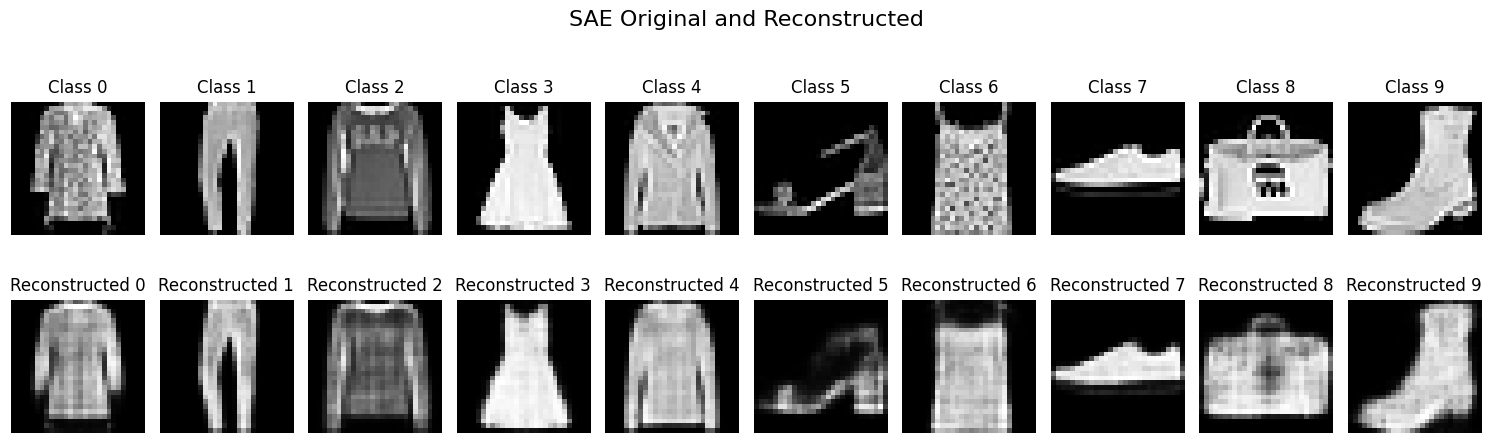

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


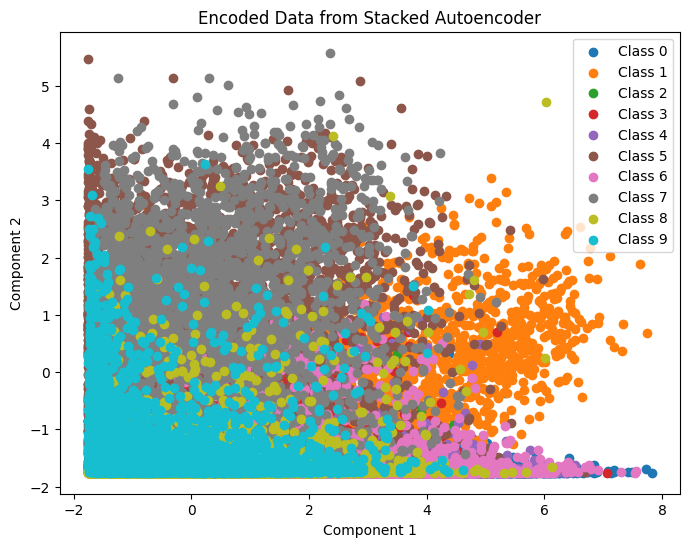

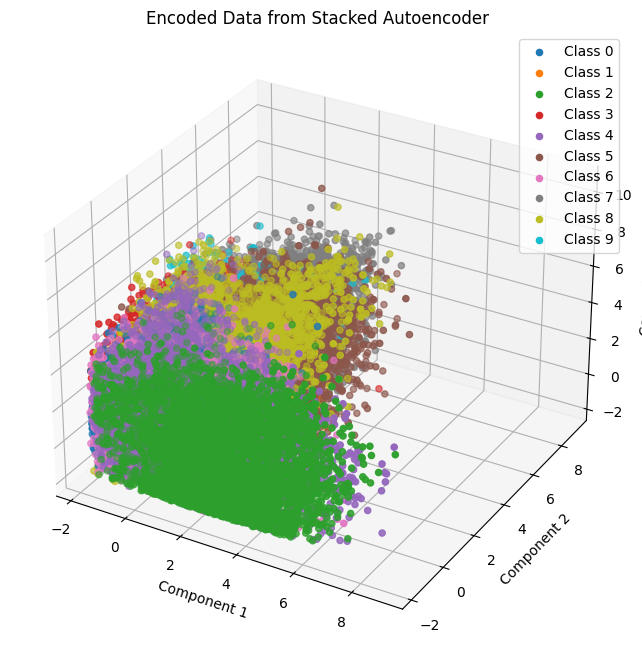

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
For the test data after SAE reduction:
--------------------------------------------------
Time taken (MiniBatchKMeans): 0.1016 seconds
Number of clusters for MiniBatchKMeans: 10
Silhouette score (MiniBatchKMeans): 0.16
CH Index (MiniBatchKMeans): 1474.45
DB Index (MiniBatchKMeans): 1.82
ARI Index (MiniBatchKMeans): 0.37
--------------------------------------------------
Time taken (DBSCAN): 8.1260 seconds
Number of clusters for DBSCAN: 45
Silhouette score (DBSCAN): -0.35
CH Index (DBSCAN): 49.00
DB Index (DBSCAN): 1.62
ARI Index (DBSCAN): 0.05
--------------------------------------------------
Time taken (Agglomerative Clustering): 36.2028 seconds
Number of clusters for Agglomerative Clustering: 10
Silhouette score (Agglomerative Clustering): 0.14
CH Index (Agglomerative Clustering): 1324.85
DB Index (Agglomerative Clustering): 1.82
ARI Index (Agglomerative Clustering): 0.32
--------------------------------------------------


In [ ]:
#Stacked Autoencoder with functional model

print("=== Stacked Autoencoder ===")

start_time = time.time()
# Encoder
inputs = keras.Input(shape=(28,28))
lr_flatten = keras.layers.Flatten()(inputs)
lr1 = keras.layers.Dense(392, activation="selu")(lr_flatten)
lr2 = keras.layers.Dense(196, activation="selu")(lr1)
lr3 = keras.layers.Dense(98, activation="selu")(lr2)
# Decoder
lr4 = keras.layers.Dense(196, activation="selu")(lr3)
lr5 = keras.layers.Dense(392, activation="selu")(lr4)
lr6 = keras.layers.Dense(28 * 28, activation="sigmoid")(lr5)
outputs = keras.layers.Reshape([28, 28])(lr6)
stacked_ae = keras.models.Model(inputs,outputs)
stacked_ae.compile(loss="binary_crossentropy",optimizer=keras.optimizers.SGD(1.5))
stacked_ae.summary()

h_stack = stacked_ae.fit(x_train_orig_form, x_train_orig_form, epochs=20,validation_data=[x_val_orig_form, x_val_orig_form])

end_time = time.time()
sae_training_time = end_time - start_time

# Display the Original and Reconstructed  Images
display_original_and_reconstructed(stacked_ae, x_train_orig_form, y_train, title="SAE Original and Reconstructed")

# Extract the encoder model from the Stacked Autoencoder
encoder = keras.models.Model(inputs, lr3)  # 'lr3' is the bottleneck layer
encoded_train = encoder.predict(x_train_orig_form)


# We limit the bottleneck layer to 2 dimensions if we want a 2D view
encoder_2d = keras.models.Model(inputs, keras.layers.Dense(2, activation="selu")(lr3))
encoded_train_2d = encoder_2d.predict(x_train_orig_form)

#  We limit the bottleneck layer to 3 dimensions if we want 3D view
encoder_3d = keras.models.Model(inputs, keras.layers.Dense(3, activation="selu")(lr3))
encoded_train_3d = encoder_3d.predict(x_train_orig_form)

# 2D and 3D Projections
plot_2d(encoded_train_2d, y_train, title="Encoded Data from Stacked Autoencoder")
plot_3d(encoded_train_3d, y_train, title="Encoded Data from Stacked Autoencoder")

# Encode test data with SAE
test_images_sae = encode_with_technique(stacked_ae, x_test_orig_form)

# Reshape the encoded test images to be 2D for clustering
test_images_sae_flat = test_images_sae.reshape(test_images_sae.shape[0], -1)  # Flatten each image

# Evaluate performance of clustering algorithms and store the results
print("For the test data after SAE reduction:")
print("-" * 50)

# Clustering performance for kmean after applying dimensionality reduction
evaluate_and_store_results(test_images_sae_flat, y_test, "SAE", "MiniBatchKMeans",kmeans,sae_training_time)
print("-" * 50)

# Clustering performance for dbscan after applying dimensionality reduction
evaluate_and_store_results(test_images_sae_flat, y_test, "SAE", "DBSCAN",dbscan,sae_training_time)
print("-" * 50)

# Clustering performance for Agglomerative Clustering after applying dimensionality reduction
evaluate_and_store_results(test_images_sae_flat, y_test, "SAE", "Agglomerative Clustering",agglo,sae_training_time)
print("-" * 50)



=== UMAP ===


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:3204: UserWarning: Inverse transform works best with low dimensional embeddings. Results may be poor, or this approach to inverse transform may fail altogether! If you need a high dimensional latent space and inverse transform operations consider using an autoencoder.
  warn(


Reconstruction not supported or failed: QH6235 qhull error (qh_memalloc): negative request size (-163060024).  Did int overflow due to high-D?

While executing:  | qhull d QJ
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2054017131  delaunay  Qbbound-last-qj  Q3-no-merge-vertices-dim-high
  Pgood  _run 1  QJoggle 3e-08  _joggle-seed 16807  _max-width 12
  Error-roundoff 8.9e-13  Visible-distance 8.9e-13  U-max-coplanar 8.9e-13
  Width-outside 1.8e-12  _wide-facet 5.3e-12  _maxoutside 9.2e-11
Last point added to hull was p19804.

At error exit:

Delaunay triangulation by the convex hull of 48000 points in 51-d:

  Number of input sites: 58
  Total number of nearly incident points: 47942
  Number of Delaunay regions: 5554922

Statistics for:  | qhull d QJ

  Number of points processed: 57
  Number of hyperplanes created: 1458906
  Number of facets in hull: 5766044
  Number of distance tests for qhull: 2085939
  Input joggled by: 3e-08




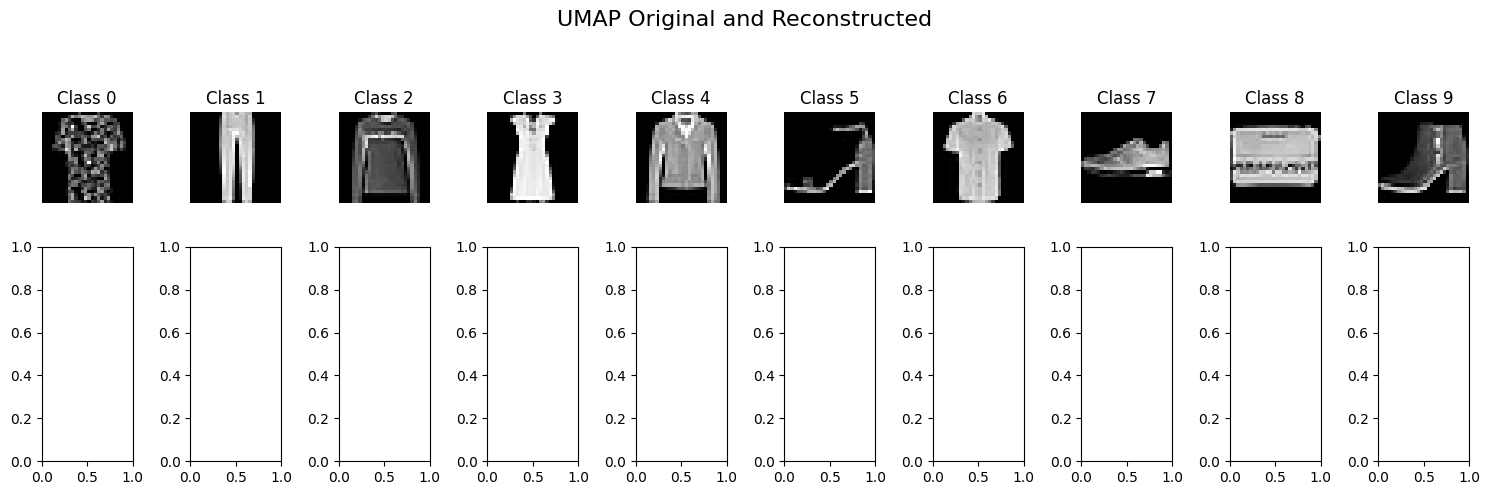

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


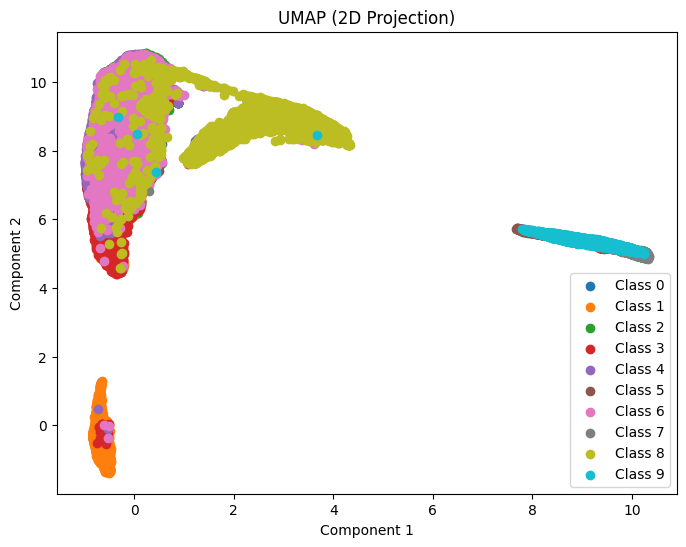

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


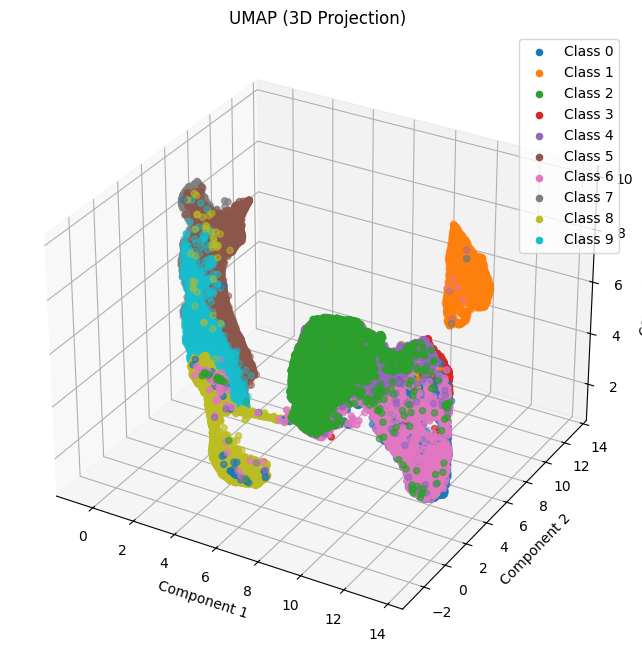

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


For the test data after UMAP reduction:
--------------------------------------------------
Time taken (MiniBatchKMeans): 0.0339 seconds
Number of clusters for MiniBatchKMeans: 10
Silhouette score (MiniBatchKMeans): 0.48
CH Index (MiniBatchKMeans): 19873.43
DB Index (MiniBatchKMeans): 0.82
ARI Index (MiniBatchKMeans): 0.48
--------------------------------------------------
Time taken (DBSCAN): 1.2968 seconds
Number of clusters for DBSCAN: 4
Silhouette score (DBSCAN): 0.59
CH Index (DBSCAN): 8081.66
DB Index (DBSCAN): 0.51
ARI Index (DBSCAN): 0.22
--------------------------------------------------
Time taken (Agglomerative Clustering): 7.4735 seconds
Number of clusters for Agglomerative Clustering: 10
Silhouette score (Agglomerative Clustering): 0.45
CH Index (Agglomerative Clustering): 19915.42
DB Index (Agglomerative Clustering): 0.87
ARI Index (Agglomerative Clustering): 0.46
--------------------------------------------------


In [ ]:
print("\n=== UMAP ===")

start_time=time.time()
umap = UMAP(n_components=50,random_state=42)  # Reducing to 50 components
X_umap = umap.fit_transform(x_train_scaled)  # Fit UMAP and transform
end_time=time.time()
umap_time=end_time-start_time

display_original_and_reconstructed(umap, x_train_orig_form, y_train, title="UMAP Original and Reconstructed")


# UMAP 2D projection
start_time_2d = time.time()  # Start time for 2D
umap_2d = UMAP(n_components=2)
X_umap_2d = umap.fit_transform(x_train_scaled)
end_time_2d = time.time()  # End time for 2D
umap_time_2d = end_time_2d - start_time_2d  # Calculate elapsed time for 2D
plot_2d(X_umap_2d, y_train, "UMAP (2D Projection)")

# UMAP 3D projection
start_time_3d = time.time()  # Start time for 3D
umap_3d = UMAP(n_components=3)
X_umap_3d = umap_3d.fit_transform(x_train_scaled)
end_time_3d = time.time()  # End time for 3D
umap_time_3d = end_time_3d - start_time_3d  # Calculate elapsed time for 3D
plot_3d(X_umap_3d, y_train, "UMAP (3D Projection)")


# Encode test data with
test_images_umap = encode_with_technique(umap, x_test_scaled)

# Evaluate performance of clustering algorithms and store the results
print("For the test data after UMAP reduction:")
print("-" * 50)

# Clustering performance for kmean after applying dimensionality reduction
evaluate_and_store_results(test_images_umap, y_test, "UMAP", "MiniBatchKMeans",kmeans,umap_time)
print("-" * 50)

# Clustering performance for dbscan after applying dimensionality reduction
evaluate_and_store_results(test_images_umap, y_test, "UMAP", "DBSCAN",dbscan,umap_time)
print("-" * 50)

# Clustering performance for Agglomerative Clustering after applying dimensionality reduction
evaluate_and_store_results(test_images_umap, y_test, "UMAP", "Agglomerative Clustering",agglo,umap_time)
print("-" * 50)



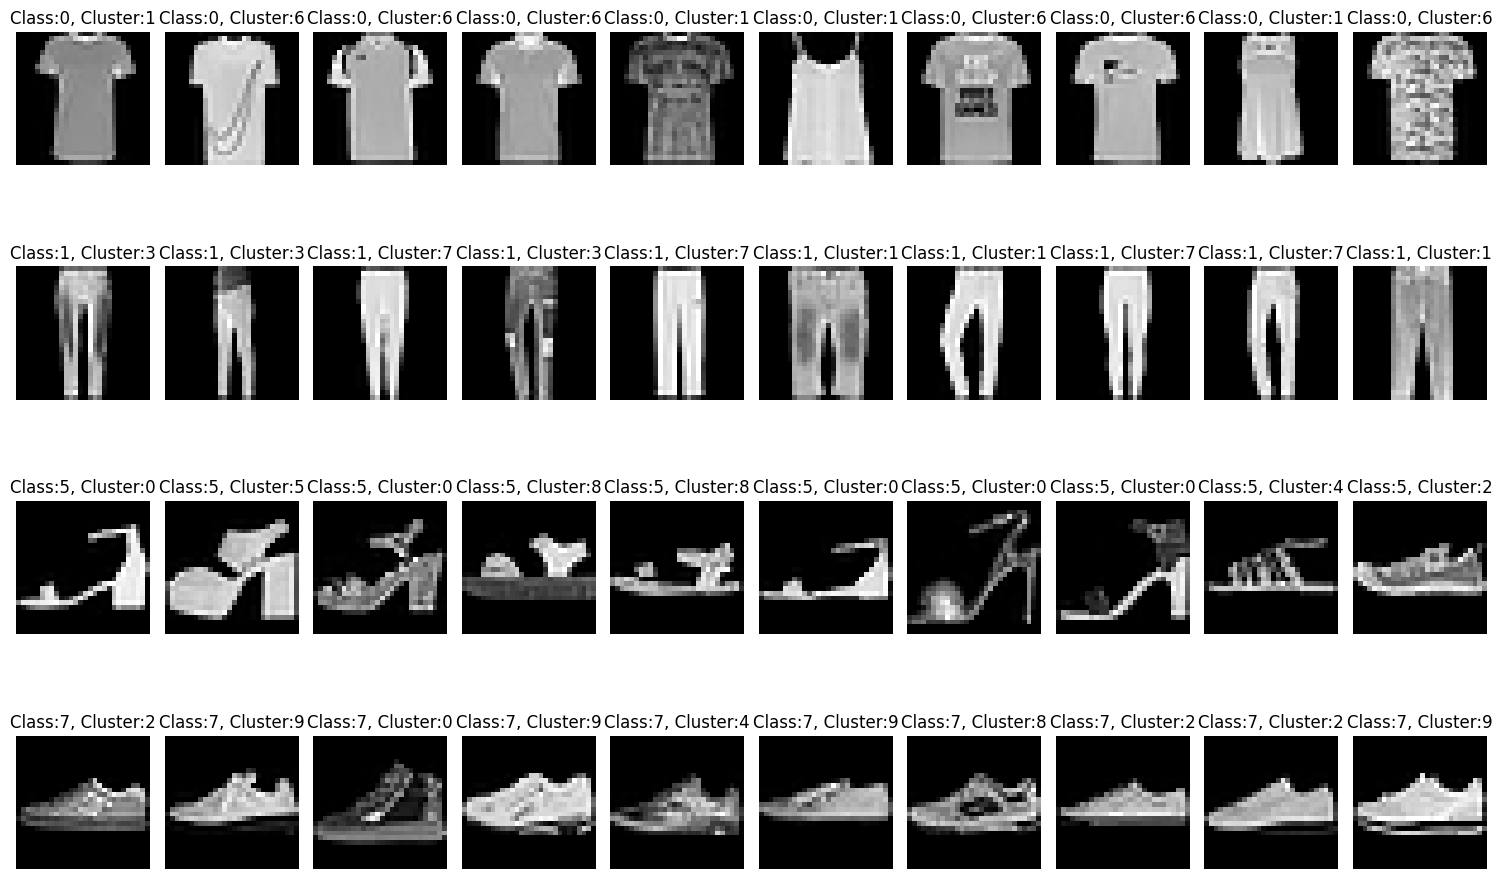

In [ ]:
# Chosing category (e.g. T-shirt/Top, Trouser, Sandal, Sneaker)
selected_classes = [0, 1, 5, 7]  # Example: T-shirt/top, Trouser, Sandal, Sneaker
num_samples_per_class = 10 # Number of random samples per class

#Filtering data and choosing random sample
x_filtered = []
y_filtered = []

for class_label in selected_classes:
    class_indices = np.where(y_train == class_label)[0]  # Get indices for the current class
    random_indices = np.random.choice(class_indices, size=num_samples_per_class, replace=False)  # Select random indices
    x_filtered.extend(x_train_scaled[random_indices])  # Add selected data points to the filtered list
    y_filtered.extend([class_label] * num_samples_per_class)  # Add corresponding labels

x_filtered = np.array(x_filtered)  # Convert to NumPy array
y_filtered = np.array(y_filtered)  # Convert to NumPy array

# Flattening data (kmowing that is already normilized)
x_flattened = x_filtered.reshape(len(x_filtered), -1)

# Example usage with k-means:
kmeans_labels = kmeans.fit_predict(x_flattened)

# Visualize the clusters
fig, axes = plt.subplots(len(selected_classes), num_samples_per_class, figsize=(15, 10))

for i, class_label in enumerate(selected_classes):
    for j in range(num_samples_per_class):
        index = i * num_samples_per_class + j
        image = x_filtered[index].reshape(28, 28)  # Reshape to original image dimensions
        cluster_label = kmeans_labels[index]

        axes[i, j].imshow(image, cmap='gray')
        axes[i, j].set_title(f'Class:{class_label}, Cluster:{cluster_label}')
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#mount gdrive directory
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#create a folder to store results
import os
# Specify the Drive Path
drive_path = '/content/drive/My Drive/MachineLearning/Exc2'

# Check if the folder exists, and create it if necessary
if not os.path.exists(drive_path):
    os.makedirs(drive_path)

print("-" * 50)

# Save CSV to Drive
csv_filename = 'results_data.csv'
csv_path = os.path.join(drive_path, csv_filename)
results_df.to_csv(csv_path, index=False)

print(f"Results saved to: {csv_path}")


--------------------------------------------------
Results saved to: /content/drive/My Drive/MachineLearning/Exc2/results_data.csv
